In [1]:
%matplotlib notebook
# does not work in colab
!pip install ffmpeg

## Newton Fractal

Newton's method is used to find roots of a given equation $f(z)$ <br>
Find $z$ such that $f(z)=0$  <br>
$ z_{n+1} = z_{n} - \frac{f(z_n)}{{f}'(z_n)} $

More information can be found here:
- https://en.wikipedia.org/wiki/Newton_fractal
- https://en.wikipedia.org/wiki/Newton%27s_method
- https://mathworld.wolfram.com/NewtonsMethod.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from tqdm.notebook import tqdm
import time
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D

### define function and parameters

In [3]:
def f(z):
    return z**3 - 1

def df(z):
    return 3*z**2

# define size
# using top left and bottom right coordinates
img_size = ((0,0),(16,16))
frac_size = ((-4,-4),(4,4))
(frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
(img_x0,img_y0), (img_x1,img_y1) = img_size

# define parameters
tol = 0.001
maxIter = 20
frac_xStep = (frac_x1-frac_x0)/(img_x1-img_x0)
frac_yStep = (frac_y1-frac_y0)/(img_y1-img_y0)
params = {"tol":tol, "maxIter":maxIter, "frac_xStep":frac_xStep, "frac_yStep":frac_yStep}    

### test random values

In [4]:
z = np.random.uniform(frac_x0, frac_x1) + np.random.uniform(frac_y0, frac_y1)*1j

print("point:",z)

for i in range(1,1+params["maxIter"]):
  if abs(f(z)) < params["tol"] or np.isnan(z):
      break
  z -= f(z)/df(z)
  
if i < params["maxIter"]:
  if not np.isnan(z):
    print("converged to:",z)
    print("converged in",i,"steps")
    print("fvalue:",abs(f(z)))
    print("root:",(z.real), (z.imag), abs(z), ((z.real)**2+(z.imag)**2)**2 )
  else:
    print("escaped in",i,"steps")  
else:
  print("did not converge in",i,"steps")
  print("fvalue:",abs(f(z)))
  print("root:",abs((z)))

point: (3.1217526061326177-0.37333677688915134j)
converged to: (0.9999998715244788+2.565498638296181e-08j)
converged in 7 steps
fvalue: 3.9303587780523987e-07
root: 0.9999998715244788 2.565498638296181e-08 0.9999998715244791 0.9999994860980156


### plot fractal

In [5]:
def imgToFrac(frac_size,img_size,point):
  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_x1 -= 1.0;  img_y1 -= 1.0

  x0, y0 = point
  x1 = (x0-img_x0)*(frac_x1-frac_x0)/(img_x1-img_x0) + frac_x0
  y1 = (y0-img_y0)*(frac_y0-frac_y1)/(img_y1-img_y0) + frac_y1
  return x1,y1

def fracToImg(frac_size,img_size,point):
  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_x1 -= 1;  img_y1 -= 1

  x0, y0 = point
  x1 = int(round((x0-frac_x0)*(img_x1-img_x0)/(frac_x1-frac_x0) + img_x0))
  y1 = int(round((y0-frac_y0)*(img_y0-img_y1)/(frac_y1-frac_y0) + img_y1))
  return x1,y1

def plot_frac(frac_size,img_size,params,ax):

  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_w = img_x1 - img_x0
  img_h = img_y1 - img_y0

  data3d = []
  for x in tqdm(np.arange(frac_x0, frac_x1+params["frac_xStep"], params["frac_xStep"]), leave=False):    # have added step size to endpoints to include them
    for y in np.arange(frac_y0, frac_y1+params["frac_xStep"], params["frac_yStep"]):

      z = x+y*1j

      xda = []; yda = []; zda = []; colda = []
      for i in range(params["maxIter"]):
        fval = f(z)
        
        if (z.real > frac_x0 and z.real < frac_x1) and (z.imag > frac_y0 and z.imag < frac_y1):
          x1,y1 = fracToImg(frac_size,img_size,(z.real, z.imag))
          xda.append(x1); yda.append(y1); zda.append(i);
          
          # color depends on the angle of the roots
          angle = (180 + np.angle(z, deg=True))/360   # [0,1]
          if angle < params["tol"]:
            angle = 1 - angle
          h = angle
          colda.append(hsv_to_rgb((h,1,1)))
        else : break
        
        z -= fval/df(z)
        
      if abs(fval) < params["tol"]:
        data3d.append((xda,yda,zda,colda))
        
  return data3d

<IPython.core.display.Javascript object>


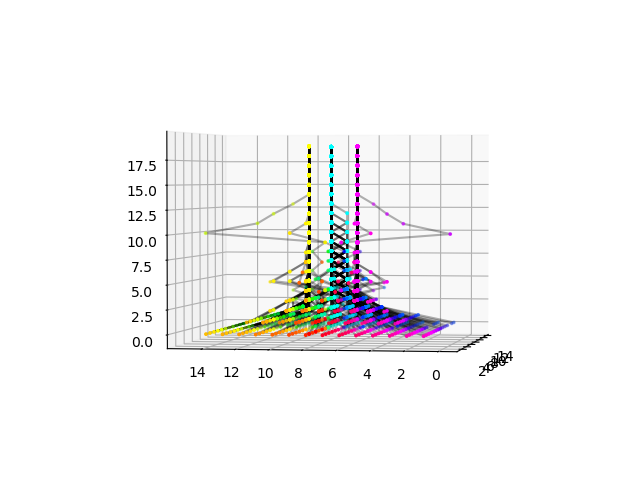

C:\Users\india\Miniconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in cdouble_scalars
C:\Users\india\Miniconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in cdouble_scalars


In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')

data3d = plot_frac(frac_size,img_size,params,ax)
for x,y,z,colrs in data3d:
  ax.plot(x,y,z, color="black", alpha=0.3)
  ax.scatter(x,y,z, color=colrs, s=3)  
  #for i in range(len(x)-2):
  #  ax.plot(x[i:i+2],y[i:i+2],z[i:i+2],c=colrs[i+1])
        
plt.show()        

In [ ]:
for angle in tqdm(range(70,210,2)):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.set_zlim3d(0, params["maxIter"])

  data3d = plot_frac(frac_size,img_size,params,ax)
  for x,y,z,colrs in data3d:
    a = (params["maxIter"]-3)/(210-70)
    tmp = int(angle*a + 3-70*a)
    x,y,z = x[:tmp],y[:tmp],z[:tmp]
    #ax.plot(x,y,z)
    #ax.scatter(x,y,z, color=colrs, s=3)
    for i in range(len(x)-2):
      ax.plot(x[i:i+2],y[i:i+2],z[i:i+2],c=colrs[i+1])
    
  ax.view_init(30,angle)
  filename='Newt/Volcano_step'+str(angle)+'.png'
  plt.savefig(filename, dpi=96)

In [ ]:
frames = 390
first_half = frames//2

def init():
  return

# animation function 
def animate(i):
  angle = 70 + (i/frames)*(210-70)
  if i < first_half:  
    ax.cla()
    data3d = plot_frac(frac_size,img_size,params,ax)
    for x,y,z,colrs in data3d:
      a = (params["maxIter"]-3)/(210-70)
      tmp = int(angle*a + 3-70*a)
      tmp = int(3 + (i/(first_half-1))*(params["maxIter"]-3))
      x,y,z, colrs = x[:tmp],y[:tmp],z[:tmp], colrs[:tmp]
      ax.plot(x,y,z, color="black", alpha=0.3)
      ax.scatter(x,y,z, color=colrs, s=3)
      #for j in range(len(x)-2):
      #  ax.plot(x[j:j+2],y[j:j+2],z[j:j+2],c=colrs[j+1])
    
    ax.set_zlim3d(0, params["maxIter"])  
  ax.view_init(30,angle)
    
    
# call the animator
fig = plt.figure()
ax = plt.axes(projection='3d')

# call the animator
anim = FuncAnimation(fig, animate, tqdm(range(frames), initial=1), init_func=init)
anim.save('newt.mp4', writer=FFMpegWriter(fps=10))